<a href="https://colab.research.google.com/github/dtabuena/Images/blob/main/Cell_Pose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install python-bioformats


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 40.3 MB 1.7 MB/s 
     |████████████████████████████████| 132 kB 11.7 MB/s 
     |████████████████████████████████| 1.3 MB 23.2 MB/s 
     |████████████████████████████████| 829 kB 55.2 MB/s 
     |████████████████████████████████| 79 kB 8.5 MB/s 
     |████████████████████████████████| 9.2 MB 55.6 MB/s 
     |████████████████████████████████| 140 kB 74.6 MB/s 
  Created wheel for python-javabridge: filename=python_javabridge-4.0.3-cp37-cp37m-linux_x86_64.whl size=1628182 sha256=727c47e8d8734f38d76b7b8f118a49ba3d120f955c7ecfa3cce3a34a635a0687
  Stored in directory: /root/.cache/pip/wheels/63/7e/91/01b1bd8d29b4323834feb5cfec49b857fb212e6efc74ce103c
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=89661b816cb481c5080f2b1885507d4cb4768021950d4390293e2e7576c468e7
  Stored in directory: /root/.cache/pip/wheels/56/b0/

In [2]:
import numpy as np
import javabridge
import bioformats
import skimage
from skimage import filters
from matplotlib import pyplot as plt
import matplotlib
import os
import scipy
from scipy import ndimage as ndi
javabridge.start_vm(class_path=bioformats.JARS)



def get_drobox_folder(link, new_filename):
    'Download a folder from dropbox and unzip'
    zipped_file_path = "/content/"+new_filename + ".zip"
    unzipped_file_path = "/content/"+new_filename
    if not( os.path.exists(zipped_file_path)):
        !wget -O $zipped_file_path $link    # download with new name
    !echo A | unzip $zipped_file_path -d $unzipped_file_path 
    return new_filename

def get_sub_files(rootdir):
    'Recursively search subfolders and return a list of all files'
    file_list =[]
    for rootdir, dirs, files in os.walk(rootdir): 
            file_list.extend([os.path.join(rootdir,f) for f in files])
    return file_list

folder = get_drobox_folder('https://www.dropbox.com/sh/rv7944fsk9p1mvk/AAC0E8ZTPkr-pfgK8zdC730Sa?dl=0', 'images')
file_list = get_sub_files(folder)
file_list.sort()

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


--2022-10-14 18:40:43--  https://www.dropbox.com/sh/rv7944fsk9p1mvk/AAC0E8ZTPkr-pfgK8zdC730Sa?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /sh/raw/rv7944fsk9p1mvk/AAC0E8ZTPkr-pfgK8zdC730Sa [following]
--2022-10-14 18:40:43--  https://www.dropbox.com/sh/raw/rv7944fsk9p1mvk/AAC0E8ZTPkr-pfgK8zdC730Sa
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc70e1236912bafe73ba208e2046.dl.dropboxusercontent.com/zip_download_get/BSPJVolGq4_Uwdt2Z21rC6dTGfvsAF4OfPf7HqxyPEa7DCuPR5iFZ2REbT-BVsHS1lBb1mZMSEkfP3HyeFqiikeqsMu8NWl1YyQ27ezaoppEbQ# [following]
--2022-10-14 18:40:44--  https://uc70e1236912bafe73ba208e2046.dl.dropboxusercontent.com/zip_download_get/BSPJVolGq4_Uwdt2Z21rC6dTGfvsAF4OfPf7HqxyPEa7DCuPR5iFZ2REbT-BVsHS1lBb1mZMSEkfP3HyeFqiikeqsMu8

In [100]:
my_reader = bioformats.get_image_reader('my_image', file_list[1])

c_dim = my_reader.rdr.getSizeC()
z_dim = my_reader.rdr.getSizeZ()
x_dim = my_reader.rdr.getSizeX()
y_dim = my_reader.rdr.getSizeY()
print(x_dim,y_dim,c_dim,z_dim)

image = np.empty([x_dim,y_dim,c_dim,z_dim])
for zi in range(z_dim):
    img_zi = my_reader.read(c=None, z=zi,rescale=True)
    image[:,:,:,zi] = img_zi


image_zproj = np.max(image,axis=3)
# image = np.expand_dims(image_zproj, axis=-1)
print(image.shape)
for ci in range(image.shape[2]):
    cim = image[:,:,ci,:]
    flat = cim.flatten()
    max= np.percentile(flat,100)
    assert max>0 , print(flat)
    cim = cim/max
    image[:,:,ci,:] = cim

800 800 3 16
(800, 800, 3, 16)


In [4]:
import os
os.environ["CELLPOSE_LOCAL_MODELS_PATH"] = "/PATH_FOR_MODELS/"

!pip install cellpose
from cellpose import models


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 169 kB 7.4 MB/s 
     |████████████████████████████████| 31.0 MB 54.3 MB/s 
     |████████████████████████████████| 4.2 MB 48.1 MB/s 


30


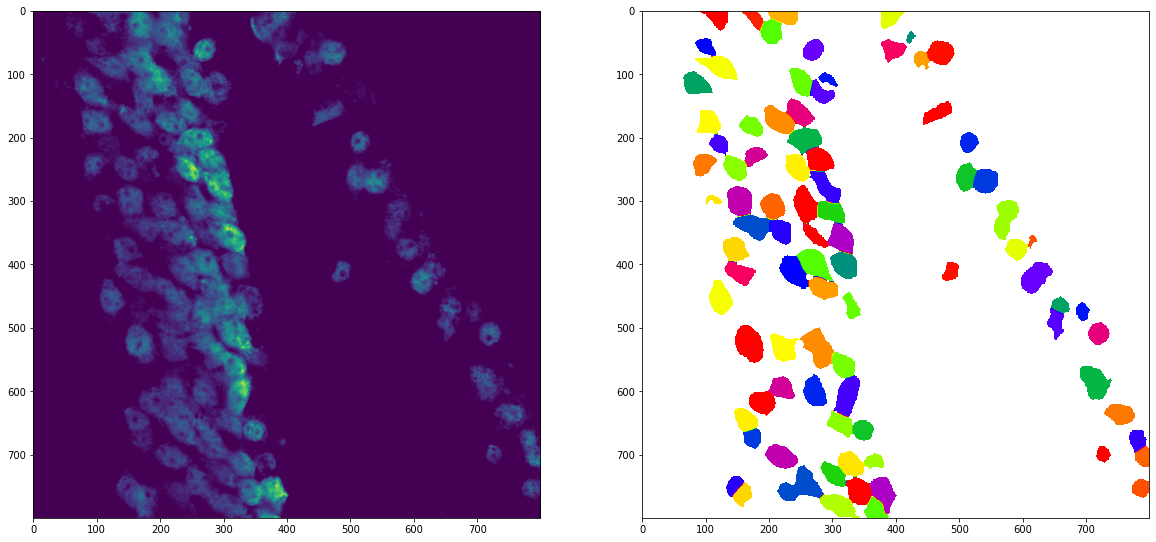

In [43]:
model = models.Cellpose(model_type='cyto')
imgs = [image[:,:,2,zi] for zi in range(image.shape[3])]
# print(imgs)

imgs=imgs[5]
masks, flows, styles, diams = model.eval(imgs, diameter=30, channels=[0,0]) 
masks = masks.astype(float)
masks[masks==0] = np.nan
n=2
psize = 10
fig, axs = plt.subplots(1,n,figsize=(psize*n,psize))
axs= axs.flatten()
axs[0].imshow(imgs)
axs[1].imshow(masks,cmap='prism')
# plt.show()
print(diams)

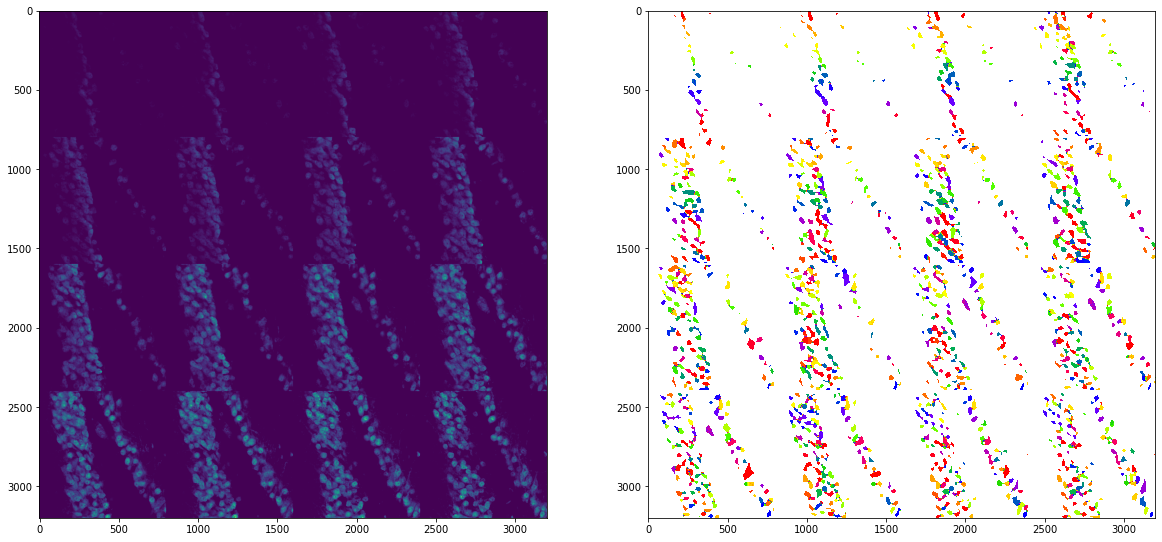

In [70]:
import skimage


model = models.Cellpose(model_type='cyto')
# imgs = [image[:,:,2,zi] for zi in range(image.shape[3])]
imgs = image[:,:,2,:]
imgs = np.transpose(imgs,(2,0,1))
# imgs = imgs[0:4,400:600,200:400]
masks, flows, styles, diams = model.eval(imgs, diameter=35, channels=[0,0], stitch_threshold=.001,do_3D=False) #anistropy
masks = masks.astype(float)
masks[masks==0] = np.nan
n=2
psize = 10
fig, axs = plt.subplots(1,n,figsize=(psize*n,psize))
axs= axs.flatten()
axs[0].imshow(skimage.util.montage(imgs))
axs[1].imshow(skimage.util.montage(masks),cmap='prism')
# plt.show()

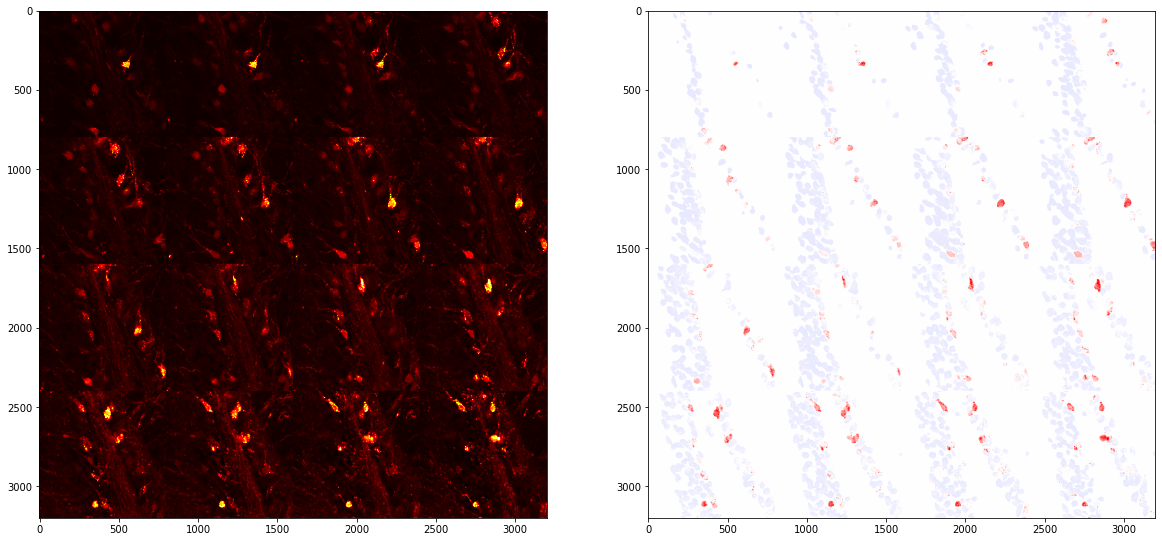

In [105]:
mask_bool = masks>0
red_stack = np.transpose(image[:,:,1,:],(2,0,1))
red_stack_med = red_stack.copy()
red_stack_med = red_stack_med-.1
red_stack_med[np.logical_not(mask_bool)]=0
n=2
psize = 10
fig, axs = plt.subplots(1,n,figsize=(psize*n,psize))
axs= axs.flatten()
axs[0].imshow(skimage.util.montage(red_stack),cmap='hot')
m = np.max(np.abs(red_stack_med.flatten()))
axs[1].imshow(skimage.util.montage(red_stack_med),cmap='bwr', vmin=-m,vmax=m)

In [99]:
red_stack = np.transpose(image[:,:,1,:],(2,0,1))
print(red_stack)

[[[0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]
  ...
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]]

 [[0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]
  ...
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]]

 [[0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]
  ...
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]]

 ...

 [[0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]
  ...
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]]

 [[0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]
  ...
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [0.5 0.5 0.5 ... 0.5 0.5 0

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# # from cellpose import models
# # from cellpose.io import imread

# # # model_type='cyto' or 'nuclei' or 'cyto2'
# # model = models.Cellpose(model_type='cyto')

# # list of files
# # PUT PATH TO YOUR FILES HERE!
# files = ['/media/carsen/DATA1/TIFFS/onechan.tif']

# imgs = [imread(f) for f in files]
# nimg = len(imgs)

# # define CHANNELS to run segementation on
# # grayscale=0, R=1, G=2, B=3
# # channels = [cytoplasm, nucleus]
# # if NUCLEUS channel does not exist, set the second channel to 0
# channels = [[0,0]]
# # IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# # channels = [0,0] # IF YOU HAVE GRAYSCALE
# # channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# # channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

# # if diameter is set to None, the size of the cells is estimated on a per image basis
# # you can set the average cell `diameter` in pixels yourself (recommended)
# # diameter can be a list or a single number for all images

# masks, flows, styles, diams = model.eval(imgs, diameter=None, channels=channels)